# Self-Driving Car Engineer Nanodegree
## Project: Vehicle Detection and Tracking
* Train a classifier to recognize if an image is car or not car.
* Define sliding windows, search and classify a single image.
* Build video processing to create output video.

In [163]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

## Load data

In [2]:
# Loading data
# Read in our vehicles and non-vehicles
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

# cloading car images
car_image = []
for impath in cars:
    car_image.append (mpimg.imread(impath))

# loading non car images
notcar_image = []
for impath in notcars:
    notcar_image.append (mpimg.imread(impath))

car_image_n = len (car_image)
notcar_image_n = len (notcar_image)

print (car_image_n)
print (notcar_image_n) 

8792
8968


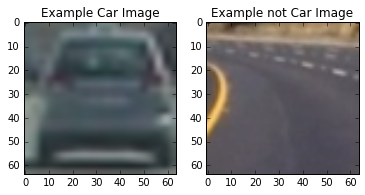

In [172]:
image_c = mpimg.imread(cars[3])
image_n = mpimg.imread(notcars[3])

fig = plt.figure()
plt.subplot(121)
plt.imshow(image_c, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(image_n, cmap='gray')    
plt.title('Example not Car Image')

Almost the same number of objects for both classes, so, I do not need to balance the number of images for the classes.

## Features extraction

Here we define functions for features extraction which they are HOG, binned color and color histogram features. To be honest most functions are based on code from the Udacity's lectures :)

Histogram of oriented gradients (HOG) features, that capture the gradient structure of each image channel and work well under different lighting conditions.

In [47]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                        visualise=False, feature_vector=feature_vec)
        return features

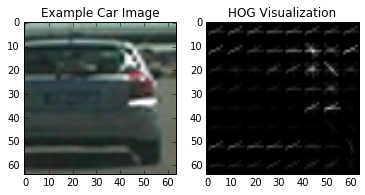

In [48]:
ind = np.random.randint(0, len(car_image))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    
    
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')    
plt.title('HOG Visualization')

In [49]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [50]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)        
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [51]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

Extracl all nessesary features from images the code is mostly from class.

In [165]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [166]:
color_space = 'YCrCb' # it Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # whhich Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

Since some feature types weight might be more than the others I decide to apply normalization.

In [167]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X) 

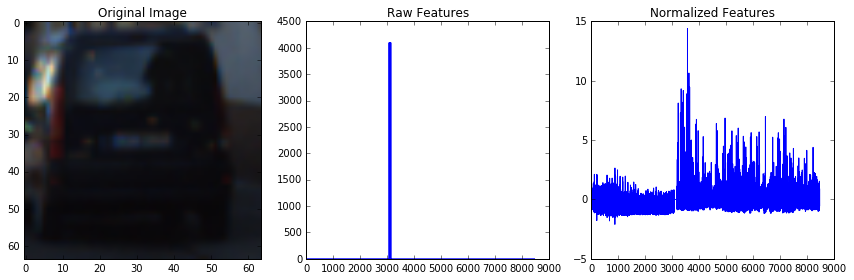

In [168]:
car_ind = np.random.randint(0, len(car_image))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## Classifier

I trained a linear SVM using 2 classes of images vehicle and non-vehicle images. The images are first loaded, then normalized features are extracted. After that they shuffled and splitet in 2 datasets train (80%) and test (20%). 

In [169]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector


# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)
print('train done!')

# randomness check

y_train[0:30].T # check randomness

train done!


array([ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
        0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.])

In [170]:
svc = LinearSVC() # Use a linear SVC 
svc.fit(X_train, y_train) # Train the classifier
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9899


## Sliding window

I define a sliding window function to generate a list of boxes with some predefined parameters. I would like to let you know these and some of the following functions are 'exactly' from the Udacity's lectures.

In [171]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [172]:
image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))

The next step I define a function that takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs then draws boxes in that color on the output.

In [173]:
# Define a function to draw bounding boxes on an image, this line from https://github.com/NikolasEnt
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

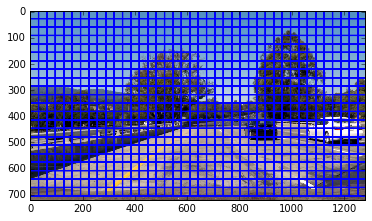

In [174]:
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

Because the upper part of the image is sky, I decided to search for vehicles in the lower part of the image only using a overlapping sliding window search. So I have some tuning to do:

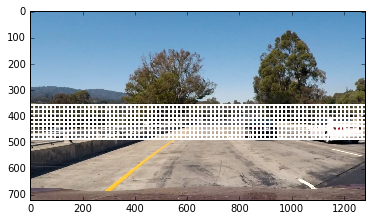

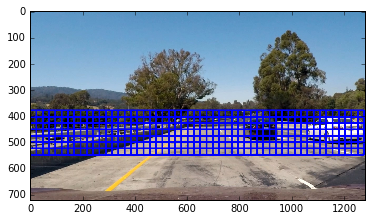

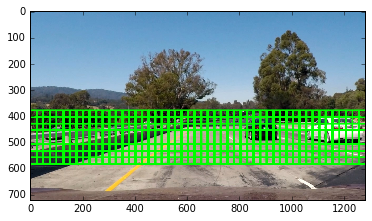

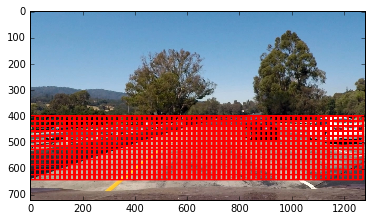

In [175]:
sizes = [(64, 64), (96, 96), (128, 128), (128, 128)]
ylims = [(360, 500), (380, 550), (380, 600), (400, 650)]
overlap = [(0.75, 0.75), (0.75, 0.75), (0.8, 0.8), (0.85, 0.85)]
colors = [(255, 255, 255), (0, 0, 255), (0, 255, 0), (255, 0, 0)]

#windows_arr = []
image = mpimg.imread('test_images/test1.jpg')
win_img = image.copy()
for i, size in enumerate(sizes):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=ylims[i], xy_window=size, xy_overlap=overlap[i])
    window_draw = draw_boxes(image, windows, color=colors[i], thick=6)                    
    plt.imshow(window_draw)
    plt.show()

In parameter tuning for slide window I chose the last one because the area is our region of interst (the area to find the cars.)

For this step I define a function to extract features from a single image window, as you can seen this function is very similar to extract_features. The difference is that previous function was for list of images but here is for a single image.

In [176]:
 def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    s_img_features = []

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        s_img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)

        s_img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        s_img_features.append(hog_features)

    return np.concatenate(s_img_features)
   

In this step I define a function that gets an image and the list of windows as inputs and returns list of windows for positive detections.

In [177]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []

    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        win_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(win_features)

        if prediction == 1:
            on_windows.append(window)
    return on_windows

### Testing sliding windows on our test images

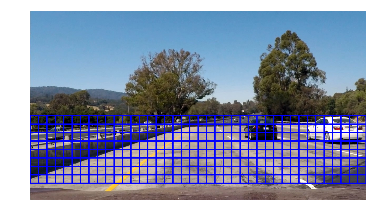

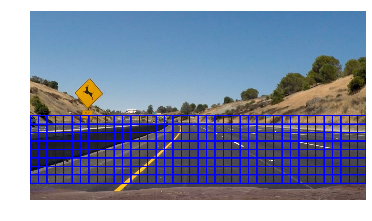

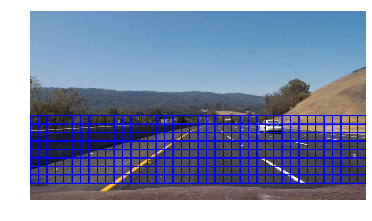

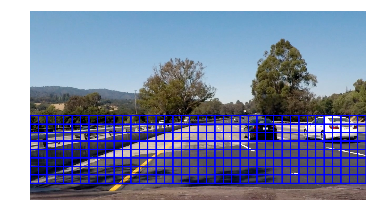

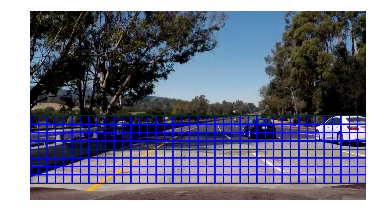

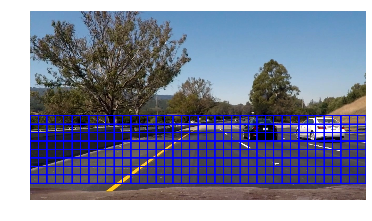

In [195]:
color_space = 'YCrCb' # it Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # whhich Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


for test in glob.glob('test_images/test*.jpg'):
    
    image = cv2.imread(test)
    draw_image = np.copy(image)
    
    boxes = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656], 
                         xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    #print (windows)
    winds = []
    winds += (search_windows(image, boxes, svc, X_scaler, color_space=color_space, 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))
    #print(winds)
    wind_img = draw_boxes(draw_image, winds, color=(255, 0, 0), thick=4) 
    plt.figure()
    plt.axis('off')
    plt.imshow(cv2.cvtColor(wind_img, cv2.COLOR_BGR2RGB))

There is something searasly wrong with my code I don't know why each time I chande values for:
color_space = 'YCrCb' # it Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # whhich Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 
I am gettting different results!! <=================== HELP NEEDED!

## Advanced Sliding Windows

This step require scaning not the whole image but only the area of cars.

### Detect new cars

So, we need to take a look at two type of the car new passing (yellow zone) and new far view (pink zone).

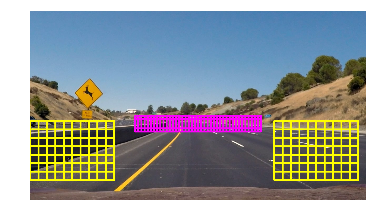

In [72]:
image = cv2.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6) 
windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 255), thick=6)                    

plt.figure()
plt.axis('off')
plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))


The next codes find windows with a car in a given range with windows of a given scale. I have to mention again that the code is from the lecture.

In [74]:
def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [179]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') #RGB2YCrCb,RGB2LUV
    if scale != 1: 
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list=[] #
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
        
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                             # (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                             # (255,0,0),8)
                box_list.append(((xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return box_list




## Video processing
The codes below are from our lecture.

In [180]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): 
    # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap <= threshold] = 0 
    return heatmap 

def draw_labeled_bboxes(img, labels):
            # Iterate through all detected cars
            for car_number in range(1, labels[1]+1):
                # Find pixels with each car_number label value
                nonzero = (labels[0] == car_number).nonzero()
                # Identify x and y values of those pixels
                nonzeroy = np.array(nonzero[0])
                nonzerox = np.array(nonzero[1])
                # Define a bounding box based on min/max x and y
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            # Return the image
            return img

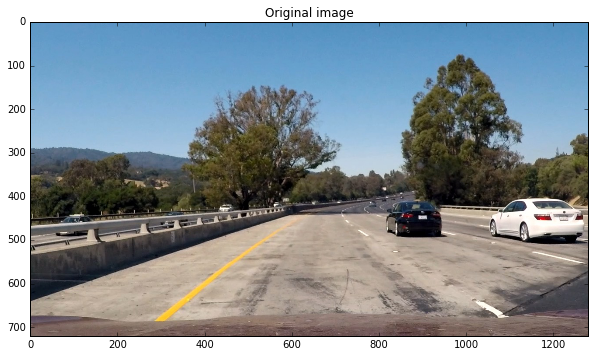

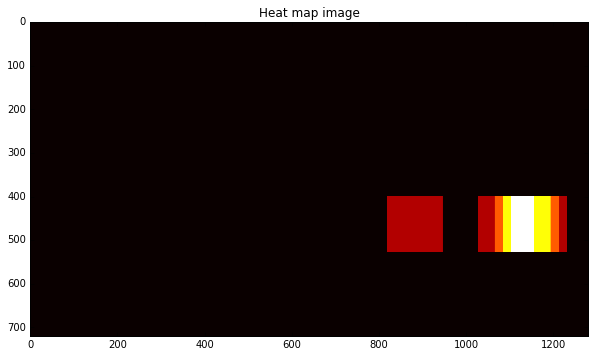

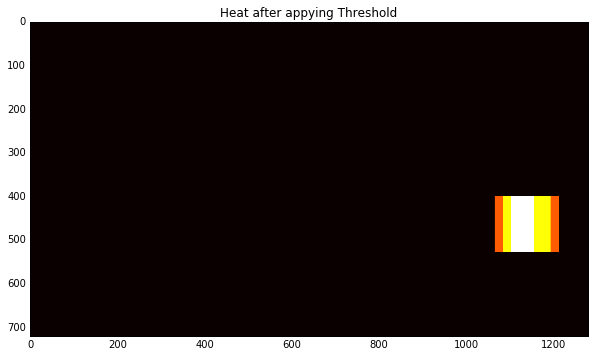

In [77]:
testing = cv2.imread('test_images/test1.jpg')
plt.figure(figsize=(10,10))
plt.title('Original image')
plt.imshow(cv2.cvtColor(testing, cv2.COLOR_BGR2RGB))
heatmap_img = np.zeros_like(testing[:,:,0])
heatmap_img = add_heat(heatmap_img, winds)
plt.figure(figsize=(10,10))
plt.title('Heat map image')
plt.imshow(heatmap_img, cmap='hot')

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.title('Heat after appying Threshold')
plt.imshow(heatmap_img, cmap='hot')

Why my result is defferent from the course I tried diffferent parameters I also tried different combination for ystart = 400, ystop = 656 but nothing changed. <============================= HELP NEEDED!

In [186]:
from scipy.ndimage.measurements import label
def process_video(img):

    color_space = 'YCrCb' # it Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # whhich Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    
    ystart = 400
    ystop = 656
    scale = 1.5
    bbox_list =find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 1)  

    # Find final boxes from heatmap using label function
    heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

## Video processing


In [187]:
from moviepy.editor import VideoFileClip

output= 'output_org.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_org.mp4
[MoviePy] Writing video output_org.mp4


100%|█████████▉| 1260/1261 [09:31<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_org.mp4 

CPU times: user 8min 15s, sys: 24.4 s, total: 8min 39s
Wall time: 9min 33s


In [188]:
from IPython.display import HTML
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_org.mp4'))

As you can see I have way too many false positive and I don't even know what the problem is! I didn't like imeplementing HOG+SVM because it was way too slow, tuning parameters were so annoying and after spending days on tuning parameters still had some cars are detected wrongly(!). So, we have enough data are there are some good way to put these data in good use like darknet (YOLO) or transfer learing (like google object detection tensorflow). These method are easier and less annoying!